In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import librosa
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from matplotlib import style
import pandas
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import csv
from sklearn import svm
import itertools
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import pandas as pd
from scipy.special import comb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectPercentile, GenericUnivariateSelect
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from scipy.stats import rankdata

In [2]:
DATADIR = "data"
CATEGORIES = ["Segmented_Laugh", "Segmented_NonLaugh"]

In [3]:
def createcombinations(n):
    elements = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
    a = list(itertools.combinations(elements, n))
    a = np.asarray(a).astype(int)
    return a

In [4]:
def create_training_data(t_frame, t_shift, n_mfccs, component, training_data, n_features):
    count=0
    error_count = 0
    laugh_counter = 0
    nonlaugh_counter = 0
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category) 
        class_num = CATEGORIES.index(category)
        for aud in os.listdir(path):
            if aud == '.DS_Store':
                continue
            
            aud_array , sr = librosa.load(os.path.join(path,aud), sr=None)
            count+=1

            mfccs = []
            
            try:
                mfcc = (librosa.feature.mfcc(aud_array, sr=sr,  n_mfcc=20,  win_length = int(sr*t_frame), hop_length = int(sr*t_shift))) 
                mfcc_temp = mfcc[component,:]
                #mfcc_temp = librosa.feature.delta(mfcc_temp)
                #mfcc_temp = librosa.feature.delta(mfcc_temp)
                mean_mfccs = np.mean(np.asarray(mfcc_temp),axis = 1)
                #var_mfccs = np.var(np.asarray(mfcc_temp), axis = 1)
                
                mfccs.append(mean_mfccs)
                #mfccs.append(var_mfccs)
                mfccs = np.asarray(mfccs).reshape(n_mfccs*n_features,1)
                
                training_data.append([mfccs.reshape(-1,1), class_num])
                if category == 'Segmented_Laugh':
                    laugh_counter +=1
                else:
                    nonlaugh_counter += 1
                    if nonlaugh_counter >= laugh_counter:
                        break

            except ValueError:
                pass
            
    return laugh_counter, nonlaugh_counter

In [5]:
def scaling(X,n_mfcc):
    for i in range(n_mfcc):
        X[:,i] = X[:,i]/(np.mean(X[:,i]))
        

    #X[:,1] = np.square(X[:,1])
        
    return X

In [6]:
n_features = 1
t_frame = 0.025
t_shift = 0.01
n_mfcc = 20
component = createcombinations(n_mfcc)

for components in component:
    training_data = []
    laugh, nonlaugh = create_training_data(t_frame, t_shift, n_mfcc, components, training_data, n_features)
    print(laugh, nonlaugh)
    
random.shuffle(training_data) 
X = []
Y = []
for features, label in training_data:
    X.append(features)
    Y.append(label)
        
X = np.array(X).reshape(-1,n_mfcc*n_features)
Y = np.array(Y)
X = scaling(X,n_mfcc)

X_train, X_test, y_train, y_test = train_test_split(
         X, Y, test_size=0.2, random_state=123)

616 604


In [9]:
#for SBS
knn = KNeighborsClassifier(n_neighbors=2) # ml_algo used = knn
sbs1 = SFS(knn, 
           k_features=3, 
           forward=False, # if forward = True then SFS otherwise SBS
           floating=False, 
           verbose=2,
           scoring='accuracy'
           )

pipe = Pipeline([('sbs', sbs1), 
                 ('knn', knn)])

param_grid = [
  {'sbs__k_features': [2,4,6,8,10,12,14,16],
   'sbs__estimator__n_neighbors': [1,3, 5, 10,15,17,19]}
  ] # dict. for tuning inside and outside hyperparameters i.e. no. of k_features and no. of neighbors( for knn ) 

gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  n_jobs=1, 
                  cv=5,
                  iid=True,
                  refit=False)

# run gridearch
gs = gs.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:42:08] Features: 19/2 -- score: 0.664083334650419[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:42:09] Features: 18/2 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:42:10] Features: 17/2 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 01:42:27] Features: 9/2 -- score: 0.6580645161290322[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 01:42:28] Features: 8/2 -- score: 0.6478241216355044[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 01:42:28] Features: 7/2 -- score: 0.6388576124922951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

[2020-01-04 01:42:29] Features: 6/2 -- sc

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:42:44] Features: 17/2 -- score: 0.6772714197657694[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.0s finished

[2020-01-04 01:42:45] Features: 16/2 -- score: 0.6785453051160879[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 01:42:46] Features: 15/2 -- score: 0.6785288678857612[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.0s finished

[2020-01-04 01:42:47] Features: 14/2 -

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 01:43:04] Features: 7/2 -- score: 0.6595027737826176[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s finished

[2020-01-04 01:43:05] Features: 6/2 -- score: 0.6582453256626258[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s finished

[2020-01-04 01:43:05] Features: 5/2 -- score: 0.6479720567084446[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished

[2020-01-04 01:43:05] Features: 4/2 -- sc

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.8s finished

[2020-01-04 01:43:24] Features: 13/4 -- score: 0.6657900143825765[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.7s finished

[2020-01-04 01:43:24] Features: 12/4 -- score: 0.6682884733922334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 01:43:25] Features: 11/4 -- score: 0.6683213478528868[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 01:43:26] Features: 10/4 -

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.0s finished

[2020-01-04 01:43:42] Features: 17/4 -- score: 0.6772714197657694[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.1s finished

[2020-01-04 01:43:43] Features: 16/4 -- score: 0.6785453051160879[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s finished

[2020-01-04 01:43:44] Features: 15/4 -- score: 0.6785288678857612[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.9s finished

[2020-01-04 01:43:45] Features: 14/4 -

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s finished

[2020-01-04 01:44:00] Features: 5/4 -- score: 0.6479720567084446[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished

[2020-01-04 01:44:00] Features: 4/4 -- score: 0.6504705157181014[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:44:01] Features: 19/6 -- score: 0.664083334650419[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:44:02] Features: 18/6 -- s

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 01:44:19] Features: 7/6 -- score: 0.6388576124922951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

[2020-01-04 01:44:20] Features: 6/6 -- score: 0.6107499486336553[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:44:21] Features: 19/6 -- score: 0.6414711321142388[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:44:22] Features: 18/6 -- 

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 01:44:38] Features: 7/6 -- score: 0.6593877131703308[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

[2020-01-04 01:44:39] Features: 6/6 -- score: 0.678594616807068[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:44:40] Features: 19/6 -- score: 0.6633408670638997[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:44:41] Features: 18/6 -- s

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:44:59] Features: 19/8 -- score: 0.6708855557838505[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:45:00] Features: 18/8 -- score: 0.6708855557838505[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:45:01] Features: 17/8 -- score: 0.6696116704335319[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 01:45:01] Features: 16/8 -

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 01:45:20] Features: 15/8 -- score: 0.6785288678857612[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 01:45:21] Features: 14/8 -- score: 0.6785453051160879[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 01:45:22] Features: 13/8 -- score: 0.6747565235257859[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 01:45:22] Features: 12/8 -

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 01:45:41] Features: 11/10 -- score: 0.6602453467359981[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 01:45:42] Features: 10/10 -- score: 0.6550923277120113[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:45:43] Features: 19/10 -- score: 0.6708855557838505[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:45:44] Features: 18/

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 01:46:04] Features: 13/10 -- score: 0.6747565235257859[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 01:46:05] Features: 12/10 -- score: 0.673499075405794[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 01:46:05] Features: 11/10 -- score: 0.673449763714814[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 01:46:06] Features: 10/10

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 01:46:28] Features: 13/12 -- score: 0.6657900143825765[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.7s finished

[2020-01-04 01:46:29] Features: 12/12 -- score: 0.6682884733922334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:46:30] Features: 19/12 -- score: 0.6414711321142388[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:46:31] Features: 18/

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.0s finished

[2020-01-04 01:46:53] Features: 17/14 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 01:46:54] Features: 16/14 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 01:46:55] Features: 15/14 -- score: 0.6666476479482438[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 01:46:55] Features: 14/

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:47:18] Features: 19/16 -- score: 0.664083334650419[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:47:19] Features: 18/16 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:47:20] Features: 17/16 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 01:47:21] Features: 16/1

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 01:47:45] Features: 11/2 -- score: 0.6602453467359981[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 01:47:45] Features: 10/2 -- score: 0.6550923277120113[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 01:47:46] Features: 9/2 -- score: 0.6486982977983594[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 01:47:46] Features: 8/2 -- 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:47:59] Features: 19/2 -- score: 0.6414711321142388[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:48:00] Features: 18/2 -- score: 0.6452763509348675[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:48:01] Features: 17/2 -- score: 0.6465831107458393[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  1

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 01:48:17] Features: 9/2 -- score: 0.6632751181425929[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 01:48:17] Features: 8/2 -- score: 0.6620176700226011[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 01:48:18] Features: 7/2 -- score: 0.6593877131703308[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

[2020-01-04 01:48:18] Features: 6/2 -- sc

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:48:32] Features: 17/4 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 01:48:33] Features: 16/4 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 01:48:34] Features: 15/4 -- score: 0.6666476479482438[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 01:48:35] Features: 14/4 -

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s finished

[2020-01-04 01:48:49] Features: 5/4 -- score: 0.6107992603246353[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished

[2020-01-04 01:48:50] Features: 4/4 -- score: 0.6194698993219643[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.2s finished

[2020-01-04 01:48:51] Features: 19/4 -- score: 0.6414711321142388[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:48:52] Features: 18/4 -- 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 01:49:08] Features: 9/4 -- score: 0.6632751181425929[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 01:49:09] Features: 8/4 -- score: 0.6620176700226011[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 01:49:09] Features: 7/4 -- score: 0.6593877131703308[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

[2020-01-04 01:49:10] Features: 6/4 -- sc

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 01:49:27] Features: 13/6 -- score: 0.6653573253675986[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 01:49:27] Features: 12/6 -- score: 0.6640670027869534[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 01:49:28] Features: 11/6 -- score: 0.6602453467359981[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 01:49:28] Features: 10/6 -

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 01:49:46] Features: 13/6 -- score: 0.6939963016231765[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 01:49:47] Features: 12/6 -- score: 0.6940127388535032[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 01:49:47] Features: 11/6 -- score: 0.6978015204438052[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 01:49:48] Features: 10/6 -

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 01:50:05] Features: 13/6 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 01:50:06] Features: 12/6 -- score: 0.672307376207109[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 01:50:06] Features: 11/6 -- score: 0.6748551469077461[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 01:50:07] Features: 10/6 --

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 01:50:25] Features: 11/8 -- score: 0.6683213478528868[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 01:50:26] Features: 10/8 -- score: 0.6657735771522499[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 01:50:26] Features: 9/8 -- score: 0.6580645161290322[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 01:50:27] Features: 8/8 -- 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:50:45] Features: 19/8 -- score: 0.6633408670638997[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:50:46] Features: 18/8 -- score: 0.6644832545716046[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:50:47] Features: 17/8 -- score: 0.6671625231148551[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 01:50:48] Features: 16/8 -

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 01:51:08] Features: 13/10 -- score: 0.6657900143825765[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 01:51:09] Features: 12/10 -- score: 0.6682884733922334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 01:51:10] Features: 11/10 -- score: 0.6683213478528868[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 01:51:10] Features: 10/

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 01:51:31] Features: 15/10 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished

[2020-01-04 01:51:32] Features: 14/10 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 01:51:32] Features: 13/10 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 01:51:33] Features: 12/

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 01:51:54] Features: 13/12 -- score: 0.6939963016231765[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 01:51:55] Features: 12/12 -- score: 0.6940127388535032[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:51:56] Features: 19/12 -- score: 0.6504540784877747[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:51:57] Features: 18/

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 01:52:19] Features: 15/14 -- score: 0.6696281076638586[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 01:52:19] Features: 14/14 -- score: 0.6696281076638586[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:52:21] Features: 19/14 -- score: 0.6414711321142388[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:52:22] Features: 18/

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:52:45] Features: 19/16 -- score: 0.6414711321142388[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:52:46] Features: 18/16 -- score: 0.6452763509348675[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:52:47] Features: 17/16 -- score: 0.6465831107458393[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 01:52:48] Features: 16/

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished

[2020-01-04 01:53:07] Features: 2/2 -- score: 0.6359020720393229[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:53:08] Features: 19/2 -- score: 0.6708855557838505[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:53:09] Features: 18/2 -- score: 0.6708855557838505[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 01:53:25] Features: 10/2 -- score: 0.6978343949044585[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 01:53:26] Features: 9/2 -- score: 0.6939963016231765[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 01:53:26] Features: 8/2 -- score: 0.6901417711115677[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 01:53:26] Features: 7/2 -- s

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:53:40] Features: 18/2 -- score: 0.6644832545716046[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:53:41] Features: 17/2 -- score: 0.6671625231148551[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 01:53:42] Features: 16/2 -- score: 0.6722745017464558[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 01:53:43] Features: 15/2 -

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 01:53:57] Features: 8/4 -- score: 0.6434385948275407[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 01:53:58] Features: 7/4 -- score: 0.6332886577842401[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

[2020-01-04 01:53:58] Features: 6/4 -- score: 0.6370604753099103[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s finished

[2020-01-04 01:53:58] Features: 5/4 -- sc

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.7s finished

[2020-01-04 01:54:16] Features: 12/4 -- score: 0.6940127388535032[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 01:54:16] Features: 11/4 -- score: 0.6978015204438052[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 01:54:17] Features: 10/4 -- score: 0.6978343949044585[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 01:54:17] Features: 9/4 --

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 01:54:33] Features: 16/4 -- score: 0.6722745017464558[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 01:54:34] Features: 15/4 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 01:54:34] Features: 14/4 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 01:54:35] Features: 13/4 -

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.2s finished

[2020-01-04 01:54:51] Features: 18/6 -- score: 0.6708855557838505[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:54:52] Features: 17/6 -- score: 0.6696116704335319[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 01:54:53] Features: 16/6 -- score: 0.6696116704335319[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 01:54:54] Features: 15/6 -

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:55:10] Features: 18/6 -- score: 0.6708691185535237[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:55:11] Features: 17/6 -- score: 0.6772714197657694[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 01:55:12] Features: 16/6 -- score: 0.6785453051160879[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 01:55:13] Features: 15/6 -

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:55:30] Features: 18/8 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:55:31] Features: 17/8 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 01:55:31] Features: 16/8 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 01:55:32] Features: 15/8 -

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 01:55:51] Features: 14/8 -- score: 0.6914320936922128[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 01:55:52] Features: 13/8 -- score: 0.6939963016231765[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 01:55:52] Features: 12/8 -- score: 0.6940127388535032[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 01:55:53] Features: 11/8 -

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 01:56:11] Features: 10/8 -- score: 0.6710334908567906[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 01:56:12] Features: 9/8 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 01:56:12] Features: 8/8 -- score: 0.6658557633038832[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:56:13] Features: 19/10 --

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 01:56:34] Features: 14/10 -- score: 0.6914320936922128[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 01:56:34] Features: 13/10 -- score: 0.6939963016231765[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 01:56:35] Features: 12/10 -- score: 0.6940127388535032[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 01:56:36] Features: 11/

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 01:56:56] Features: 16/12 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 01:56:57] Features: 15/12 -- score: 0.6666476479482438[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 01:56:58] Features: 14/12 -- score: 0.6666476479482438[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 01:56:58] Features: 13/

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 01:57:20] Features: 12/12 -- score: 0.673499075405794[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:57:21] Features: 19/12 -- score: 0.6633408670638997[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:57:22] Features: 18/12 -- score: 0.6644832545716046[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:57:23] Features: 17/1

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:57:45] Features: 18/14 -- score: 0.6708691185535237[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:57:46] Features: 17/14 -- score: 0.6772714197657694[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 01:57:47] Features: 16/14 -- score: 0.6785453051160879[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 01:57:48] Features: 15/

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:58:12] Features: 18/16 -- score: 0.6644832545716046[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:58:13] Features: 17/16 -- score: 0.6671625231148551[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 01:58:14] Features: 16/16 -- score: 0.6722745017464558[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:58:15] Features: 19/

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 01:58:31] Features: 12/2 -- score: 0.6682884733922334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 01:58:32] Features: 11/2 -- score: 0.6683213478528868[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 01:58:32] Features: 10/2 -- score: 0.6657735771522499[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 01:58:33] Features: 9/2 --

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished

[2020-01-04 01:58:45] Features: 2/2 -- score: 0.6505198274090815[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:58:47] Features: 19/2 -- score: 0.6504540784877747[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:58:48] Features: 18/2 -- score: 0.6708691185535237[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 01:59:04] Features: 10/2 -- score: 0.6710334908567906[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 01:59:04] Features: 9/2 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 01:59:05] Features: 8/2 -- score: 0.6658557633038832[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 01:59:05] Features: 7/2 -- s

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 01:59:21] Features: 16/4 -- score: 0.6696116704335319[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 01:59:21] Features: 15/4 -- score: 0.6696281076638586[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 01:59:22] Features: 14/4 -- score: 0.6696281076638586[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 01:59:23] Features: 13/4 -

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished

[2020-01-04 01:59:37] Features: 4/4 -- score: 0.6671789603451819[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 01:59:38] Features: 19/4 -- score: 0.6504540784877747[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 01:59:39] Features: 18/4 -- score: 0.6708691185535237[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 01:59:40] Features: 17/4 --

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 01:59:56] Features: 8/4 -- score: 0.6658557633038832[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 01:59:56] Features: 7/4 -- score: 0.6595027737826176[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

[2020-01-04 01:59:57] Features: 6/4 -- score: 0.6582453256626258[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s finished

[2020-01-04 01:59:57] Features: 5/4 -- sc

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 02:00:15] Features: 10/6 -- score: 0.6657735771522499[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 02:00:15] Features: 9/6 -- score: 0.6580645161290322[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 02:00:16] Features: 8/6 -- score: 0.6478241216355044[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 02:00:16] Features: 7/6 -- s

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 02:00:34] Features: 10/6 -- score: 0.6721923155948223[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 02:00:35] Features: 9/6 -- score: 0.6632751181425929[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 02:00:35] Features: 8/6 -- score: 0.6620176700226011[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 02:00:35] Features: 7/6 -- s

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 02:00:54] Features: 10/8 -- score: 0.6550923277120113[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 02:00:54] Features: 9/8 -- score: 0.6486982977983594[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 02:00:55] Features: 8/8 -- score: 0.6434385948275407[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:00:56] Features: 19/8 -- 

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 02:01:15] Features: 18/8 -- score: 0.6708691185535237[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 02:01:15] Features: 17/8 -- score: 0.6772714197657694[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:01:16] Features: 16/8 -- score: 0.6785453051160879[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:01:17] Features: 15/8 -

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:01:36] Features: 14/10 -- score: 0.6666476479482438[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:01:36] Features: 13/10 -- score: 0.6653573253675986[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 02:01:37] Features: 12/10 -- score: 0.6640670027869534[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 02:01:38] Features: 11/

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:01:58] Features: 16/10 -- score: 0.6785453051160879[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:01:59] Features: 15/10 -- score: 0.6785288678857612[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished

[2020-01-04 02:02:00] Features: 14/10 -- score: 0.6785453051160879[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:02:00] Features: 13/

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:02:21] Features: 16/12 -- score: 0.6696116704335319[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:02:22] Features: 15/12 -- score: 0.6696281076638586[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:02:22] Features: 14/12 -- score: 0.6696281076638586[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:02:23] Features: 13/

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 02:02:44] Features: 12/12 -- score: 0.672307376207109[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:02:46] Features: 19/14 -- score: 0.664083334650419[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 02:02:47] Features: 18/14 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 02:02:47] Features: 17/14

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:03:11] Features: 16/14 -- score: 0.6722745017464558[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:03:11] Features: 15/14 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:03:12] Features: 14/14 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:03:13] Features: 19/

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:03:38] Features: 14/2 -- score: 0.6666476479482438[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:03:38] Features: 13/2 -- score: 0.6653573253675986[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 02:03:39] Features: 12/2 -- score: 0.6640670027869534[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 02:03:39] Features: 11/2 -

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished

[2020-01-04 02:03:53] Features: 4/2 -- score: 0.6194698993219643[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished

[2020-01-04 02:03:53] Features: 3/2 -- score: 0.5915594822272447[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished

[2020-01-04 02:03:53] Features: 2/2 -- score: 0.5851243065543456[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:03:54] Features: 19/2 -- s

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 02:04:10] Features: 12/2 -- score: 0.673499075405794[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 02:04:11] Features: 11/2 -- score: 0.673449763714814[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 02:04:11] Features: 10/2 -- score: 0.6721923155948223[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 02:04:12] Features: 9/2 -- s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished

[2020-01-04 02:04:24] Features: 2/2 -- score: 0.6274419560304089[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:04:25] Features: 19/4 -- score: 0.664083334650419[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 02:04:26] Features: 18/4 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 02:04:43] Features: 8/4 -- score: 0.6478241216355044[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 02:04:44] Features: 7/4 -- score: 0.6388576124922951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

[2020-01-04 02:04:44] Features: 6/4 -- score: 0.6107499486336553[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s finished

[2020-01-04 02:04:44] Features: 5/4 -- sc

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 02:05:02] Features: 12/4 -- score: 0.673499075405794[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 02:05:02] Features: 11/4 -- score: 0.673449763714814[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 02:05:03] Features: 10/4 -- score: 0.6721923155948223[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 02:05:03] Features: 9/4 -- s

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.2s finished

[2020-01-04 02:05:21] Features: 16/6 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.1s finished

[2020-01-04 02:05:22] Features: 15/6 -- score: 0.6666476479482438[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:05:23] Features: 14/6 -- score: 0.6666476479482438[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:05:23] Features: 13/6 -

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:05:42] Features: 16/6 -- score: 0.6723731251284158[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:05:42] Features: 15/6 -- score: 0.6799999999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:05:43] Features: 14/6 -- score: 0.6914320936922128[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:05:44] Features: 13/6 -

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:06:01] Features: 16/6 -- score: 0.6722745017464558[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:06:02] Features: 15/6 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished

[2020-01-04 02:06:02] Features: 14/6 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:06:03] Features: 13/6 -

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:06:21] Features: 14/8 -- score: 0.6696281076638586[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:06:22] Features: 13/8 -- score: 0.6657900143825765[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 02:06:22] Features: 12/8 -- score: 0.6682884733922334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 02:06:23] Features: 11/8 -

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 02:06:41] Features: 10/8 -- score: 0.6721923155948223[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 02:06:42] Features: 9/8 -- score: 0.6632751181425929[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 02:06:42] Features: 8/8 -- score: 0.6620176700226011[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:06:43] Features: 19/8 -- 

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:07:03] Features: 16/10 -- score: 0.6696116704335319[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:07:04] Features: 15/10 -- score: 0.6696281076638586[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:07:05] Features: 14/10 -- score: 0.6696281076638586[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:07:05] Features: 13/

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 02:07:25] Features: 18/10 -- score: 0.6644832545716046[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.0s finished

[2020-01-04 02:07:26] Features: 17/10 -- score: 0.6671625231148551[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:07:27] Features: 16/10 -- score: 0.6722745017464558[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:07:28] Features: 15/

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:07:49] Features: 16/12 -- score: 0.6723731251284158[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:07:50] Features: 15/12 -- score: 0.6799999999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:07:50] Features: 14/12 -- score: 0.6914320936922128[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:07:51] Features: 13/

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 02:08:13] Features: 18/14 -- score: 0.6708855557838505[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 02:08:14] Features: 17/14 -- score: 0.6696116704335319[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:08:15] Features: 16/14 -- score: 0.6696116704335319[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:08:16] Features: 15/

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 02:08:39] Features: 18/16 -- score: 0.6708855557838505[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 02:08:40] Features: 17/16 -- score: 0.6696116704335319[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:08:41] Features: 16/16 -- score: 0.6696116704335319[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:08:42] Features: 19/

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

[2020-01-04 02:09:03] Features: 6/2 -- score: 0.6370604753099103[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s finished

[2020-01-04 02:09:03] Features: 5/2 -- score: 0.6409805440091036[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished

[2020-01-04 02:09:03] Features: 4/2 -- score: 0.6357618814306712[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished

[2020-01-04 02:09:03] Features: 3/2 -- sc

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:09:20] Features: 14/2 -- score: 0.6914320936922128[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:09:20] Features: 13/2 -- score: 0.6939963016231765[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 02:09:21] Features: 12/2 -- score: 0.6940127388535032[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 02:09:22] Features: 11/2 -

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished

[2020-01-04 02:09:35] Features: 4/2 -- score: 0.6604972262173823[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished

[2020-01-04 02:09:35] Features: 3/2 -- score: 0.6452599137045408[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished

[2020-01-04 02:09:35] Features: 2/2 -- score: 0.6363920279432916[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:09:36] Features: 19/2 -- s

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 02:09:52] Features: 12/4 -- score: 0.6640670027869534[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 02:09:53] Features: 11/4 -- score: 0.6602453467359981[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 02:09:53] Features: 10/4 -- score: 0.6550923277120113[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 02:09:54] Features: 9/4 --

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:10:10] Features: 16/4 -- score: 0.6723731251284158[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:10:10] Features: 15/4 -- score: 0.6799999999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:10:11] Features: 14/4 -- score: 0.6914320936922128[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:10:12] Features: 13/4 -

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished

[2020-01-04 02:10:26] Features: 4/4 -- score: 0.6604972262173823[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:10:27] Features: 19/4 -- score: 0.6633408670638997[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 02:10:28] Features: 18/4 -- score: 0.6644832545716046[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 02:10:29] Features: 17/4 --

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 02:10:45] Features: 8/6 -- score: 0.6434385948275407[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 02:10:46] Features: 7/6 -- score: 0.6332886577842401[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

[2020-01-04 02:10:46] Features: 6/6 -- score: 0.6370604753099103[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:10:47] Features: 19/6 -- s

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 02:11:05] Features: 8/6 -- score: 0.6901417711115677[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 02:11:05] Features: 7/6 -- score: 0.677402917608383[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

[2020-01-04 02:11:05] Features: 6/6 -- score: 0.6800164372303266[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:11:06] Features: 19/6 -- sc

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 02:11:24] Features: 8/6 -- score: 0.6658557633038832[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 02:11:24] Features: 7/6 -- score: 0.6595027737826176[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

[2020-01-04 02:11:24] Features: 6/6 -- score: 0.6582453256626258[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:11:26] Features: 19/8 -- s

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 02:11:45] Features: 18/8 -- score: 0.6452763509348675[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 02:11:45] Features: 17/8 -- score: 0.6465831107458393[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:11:46] Features: 16/8 -- score: 0.6723731251284158[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:11:47] Features: 15/8 -

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:12:06] Features: 14/8 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:12:06] Features: 13/8 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 02:12:07] Features: 12/8 -- score: 0.672307376207109[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 02:12:08] Features: 11/8 --

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 02:12:27] Features: 18/10 -- score: 0.6452763509348675[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 02:12:28] Features: 17/10 -- score: 0.6465831107458393[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:12:29] Features: 16/10 -- score: 0.6723731251284158[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:12:30] Features: 15/

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 02:12:49] Features: 10/10 -- score: 0.6710334908567906[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:12:50] Features: 19/12 -- score: 0.664083334650419[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.1s finished

[2020-01-04 02:12:51] Features: 18/12 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.0s finished

[2020-01-04 02:12:52] Features: 17/1

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:13:14] Features: 16/12 -- score: 0.6785453051160879[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:13:15] Features: 15/12 -- score: 0.6785288678857612[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished

[2020-01-04 02:13:15] Features: 14/12 -- score: 0.6785453051160879[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:13:16] Features: 13/

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:13:39] Features: 16/14 -- score: 0.6723731251284158[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:13:40] Features: 15/14 -- score: 0.6799999999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:13:40] Features: 14/14 -- score: 0.6914320936922128[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:13:41] Features: 19/

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 02:14:05] Features: 18/16 -- score: 0.6708691185535237[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 02:14:06] Features: 17/16 -- score: 0.6772714197657694[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:14:07] Features: 16/16 -- score: 0.6785453051160879[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:14:08] Features: 19/

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:14:26] Features: 16/2 -- score: 0.6696116704335319[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:14:26] Features: 15/2 -- score: 0.6696281076638586[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:14:27] Features: 14/2 -- score: 0.6696281076638586[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:14:28] Features: 13/2 -

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

[2020-01-04 02:14:42] Features: 6/2 -- score: 0.6800164372303266[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s finished

[2020-01-04 02:14:42] Features: 5/2 -- score: 0.6722909389767825[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished

[2020-01-04 02:14:42] Features: 4/2 -- score: 0.6671789603451819[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished

[2020-01-04 02:14:42] Features: 3/2 -- sc

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:14:59] Features: 14/2 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:14:59] Features: 13/2 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 02:15:00] Features: 12/2 -- score: 0.672307376207109[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 02:15:01] Features: 11/2 --

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished

[2020-01-04 02:15:14] Features: 4/4 -- score: 0.6357618814306712[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:15:15] Features: 19/4 -- score: 0.6708855557838505[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 02:15:16] Features: 18/4 -- score: 0.6708855557838505[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 02:15:17] Features: 17/4 --

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 02:15:33] Features: 8/4 -- score: 0.6901417711115677[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished

[2020-01-04 02:15:33] Features: 7/4 -- score: 0.677402917608383[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

[2020-01-04 02:15:34] Features: 6/4 -- score: 0.6800164372303266[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s finished

[2020-01-04 02:15:34] Features: 5/4 -- sco

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 02:15:51] Features: 12/4 -- score: 0.672307376207109[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 02:15:52] Features: 11/4 -- score: 0.6748551469077461[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 02:15:52] Features: 10/4 -- score: 0.6710334908567906[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 02:15:53] Features: 9/4 -- 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:16:10] Features: 14/6 -- score: 0.6696281076638586[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:16:10] Features: 13/6 -- score: 0.6657900143825765[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 02:16:11] Features: 12/6 -- score: 0.6682884733922334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 02:16:12] Features: 11/6 -

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:16:29] Features: 14/6 -- score: 0.6785453051160879[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:16:30] Features: 13/6 -- score: 0.6747565235257859[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 02:16:30] Features: 12/6 -- score: 0.673499075405794[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished

[2020-01-04 02:16:31] Features: 11/6 --

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:16:48] Features: 14/8 -- score: 0.6666476479482438[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:16:49] Features: 13/8 -- score: 0.6653573253675986[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 02:16:50] Features: 12/8 -- score: 0.6640670027869534[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.7s finished

[2020-01-04 02:16:50] Features: 11/8 -

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 02:17:09] Features: 10/8 -- score: 0.6978343949044585[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2020-01-04 02:17:09] Features: 9/8 -- score: 0.6939963016231765[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished

[2020-01-04 02:17:10] Features: 8/8 -- score: 0.6901417711115677[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:17:11] Features: 19/8 -- 

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.2s finished

[2020-01-04 02:17:31] Features: 18/10 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.1s finished

[2020-01-04 02:17:32] Features: 17/10 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:17:33] Features: 16/10 -- score: 0.6679296992302951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:17:34] Features: 15/

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished

[2020-01-04 02:17:53] Features: 10/10 -- score: 0.6978343949044585[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:17:54] Features: 19/10 -- score: 0.6504540784877747[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 02:17:55] Features: 18/10 -- score: 0.6708691185535237[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 02:17:56] Features: 17/

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished

[2020-01-04 02:18:16] Features: 12/12 -- score: 0.6640670027869534[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:18:17] Features: 19/12 -- score: 0.6708855557838505[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 02:18:18] Features: 18/12 -- score: 0.6708855557838505[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.9s finished

[2020-01-04 02:18:19] Features: 17/

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.9s finished

[2020-01-04 02:18:40] Features: 16/12 -- score: 0.6722745017464558[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2020-01-04 02:18:41] Features: 15/12 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished

[2020-01-04 02:18:42] Features: 14/12 -- score: 0.6722909389767824[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2020-01-04 02:18:43] Features: 13/

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2020-01-04 02:19:06] Features: 14/14 -- score: 0.6785453051160879[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2020-01-04 02:19:07] Features: 19/14 -- score: 0.6633408670638997[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-01-04 02:19:08] Features: 18/14 -- score: 0.6644832545716046[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.0s finished

[2020-01-04 02:19:09] Features: 17/

In [11]:
index_0 = []
index_1 = []
result = []
for i in range(len(gs.cv_results_['params'])):
    dic = gs.cv_results_['params'][i].values()
    lis = list(dic)
    index_0.append(int(lis[0]))
    result.append(float(gs.cv_results_['mean_test_score'][i]))
    index_1.append(int(lis[1]))

    
dataframe  = pd.DataFrame(columns=['sbs__estimator__n_neighbors','sbs__k_features','Test Accuracy'])
dataframe['sbs__estimator__n_neighbors'] = np.array(index_0) 
#change the name of 0th column for different algos. i.e ex. for RF name = 'sfs__estimator__n_trees'
dataframe['sbs__k_features'] = np.array(index_1)
dataframe['Test Accuracy'] = np.array(result)

In [12]:
pipe.set_params(**gs.best_params_).fit(X_train, y_train)
print('Best features:', pipe.steps[0][1].k_feature_idx_)

print('Best score:', gs.best_score_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.6s finished

[2020-01-04 02:20:01] Features: 19/14 -- score: 0.6485871271585556[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.0s finished

[2020-01-04 02:20:03] Features: 18/14 -- score: 0.6721088435374151[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.3s finished

[2020-01-04 02:20:04] Features: 17/14 -- score: 0.6854264782836212[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Don

Best features: (0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 16, 18)
Best score: 0.6413934426229508


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.0s finished

[2020-01-04 02:20:08] Features: 14/14 -- score: 0.7069544740973314

In [13]:
dataframe.to_csv('knn_sbs.csv')
# change the address accordingly

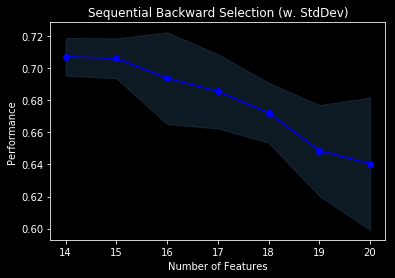

In [15]:
style.use('dark_background')
fig1 = plot_sfs(sbs1.get_metric_dict(), kind='std_dev')
plt.title('Sequential Backward Selection (w. StdDev)')
#plt.grid()
plt.show()